## Import Data: Election result in Yamanashi prefecture and Bugdet solvency by town

The election results in Yamanashi prefecture have been downloaded by scraping 選挙ドットコム, and the budget solvency data have been downloaded from 地域番付 web site. The solvency score is defined as the budget income expense divided by the budget expense, so it takes 1 if the budget balances and takes less than 1 if the local government spends more than it earns via tax.

Our hypothesis is that towns with higher divirsity score tends to have higher the budget solvency score, and we are going to validate it with the data.

In [1]:
import pandas as pd

zaisei = pd.read_table("./data/地方自治体財政健全力.tsv", sep='\t')
df_all = pd.read_csv('./data/election_result_yamanashi.txt', sep='\t')


The data on the budget solvency in Japan has town-level granularity, and the election result data have candidate-level guranularity. To merge the data, we first summarise the election result by town level. By so doing, we also calculate the diversity metric for each town, which is the skewness in the gender and age distribution.

In [3]:
# mean
df_smry_town_mean = df_all[(df_all.is_elected=='Y') & (df_all.prefecture=='山梨県')].\
    groupby(['prefecture','town','town_name'])['age','is_male'].\
    mean().reset_index().rename(columns={'age':'mean_age', 'is_male':'mean_male_percentage'})

df_smry_town_std = df_all[(df_all.is_elected=='Y') & (df_all.prefecture=='山梨県')].\
    groupby(['prefecture','town','town_name'])['age','is_male'].\
    std().reset_index().rename(columns={'age':'std_age', 'is_male':'std_male_percentage'})

df_smry_town_skew = df_all[(df_all.is_elected=='Y') & (df_all.prefecture=='山梨県')].\
    groupby(['prefecture','town','town_name'])['age','is_male'].\
    skew().reset_index().rename(columns={'age':'skew_age', 'is_male':'skew_male_percentage'})

df_smry_town_skew.head(5)

/Users/okada/anaconda3/envs/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/okada/anaconda3/envs/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/Users/okada/anaconda3/envs/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


,prefecture,town,town_name,skew_age,skew_male_percentage
0,山梨県,上野原市議会議員選挙,上野原市,-1.178384,-4.000000
1,山梨県,中央市議会議員選挙,中央市,-1.389266,-1.955761
2,山梨県,丹波山村議会議員選挙,丹波山村,-0.749703,0.000000
3,山梨県,北杜市議会議員選挙,北杜市,-1.498535,-3.058676
4,山梨県,南アルプス市議会議員選挙,南アルプス市,-1.382656,-3.058676


We combine the summarised data together to form one data set.

In [5]:
df_smry_town = df_smry_town_mean.\
    merge(df_smry_town_std, on=['prefecture','town','town_name'], how='inner').\
    merge(df_smry_town_skew, on=['prefecture','town','town_name'], how='inner')
df_smry_town.head(3)

,prefecture,town,town_name,mean_age,mean_male_percentage,std_age,std_male_percentage,skew_age,skew_male_percentage
0,山梨県,上野原市議会議員選挙,上野原市,68.187500,0.937500,10.173290,0.250000,-1.178384,-4.000000
1,山梨県,中央市議会議員選挙,中央市,62.666667,0.833333,10.312756,0.383482,-1.389266,-1.955761
2,山梨県,丹波山村議会議員選挙,丹波山村,53.500000,1.000000,12.723993,0.000000,-0.749703,0.000000


The data have the prefecture name, town name, the mean, the standard deviation and the skewness of age and male percentage. We can now merge the data with the budget solvency data that have the town-level granularity.

In [6]:
df_smry_town_final = df_smry_town.\
    merge(zaisei, left_on='town_name', right_on='town', how='left').\
    drop(['town_y','pref'], axis=1)
df_smry_town_final.to_csv('./data/election_result_yamanashi_summary.tsv', sep='\t', index=False)
df_smry_town_final.head(3)


,prefecture,town_x,town_name,mean_age,mean_male_percentage,std_age,std_male_percentage,skew_age,skew_male_percentage,score
0,山梨県,上野原市議会議員選挙,上野原市,68.187500,0.937500,10.173290,0.250000,-1.178384,-4.000000,0.50
1,山梨県,中央市議会議員選挙,中央市,62.666667,0.833333,10.312756,0.383482,-1.389266,-1.955761,0.73
2,山梨県,丹波山村議会議員選挙,丹波山村,53.500000,1.000000,12.723993,0.000000,-0.749703,0.000000,0.05


## Exploratory Data Analysis
We will first conduct a quick initial analysis to see the distribution of the data and the correlation among the variables. Our hypotheis is that 

1. The diversity of the council member positivly contributes the performance of the council in terms of the budget solvency.
2. If the hypothesis holds, we should be able to see the correaltion between the solvency and the diversity of the local council members.

We measure the diversity by the skewness of the data. Our variable ```is_male``` is 1 if the council member is male and 0 otherwise. The skewness is 0 if the number of male and female members is equal, and negative if the percentage of male members is greater than 50%. By the same token, the skewness of the age of each council member is zero if we have equal number of members for each age group, and it is negative when the number of elderly members is high.

### Correlation coefficient

In [9]:
import numpy as np
np.round(df_smry_town_final[['score','skew_age','skew_male_percentage']].corr(), 2)

,score,skew_age,skew_male_percentage
score,1.00,-0.27,-0.19
skew_age,-0.27,1.00,0.27
skew_male_percentage,-0.19,0.27,1.00


The correlation coefficient matrix among the budget solvency score and the skewness of the age and the gender shows that the skewness, or our definition of the diversity, is negatively correlated with the budget solvency score. The skewness of the age has -0.27 correlation coefficient with the budget solvency score. It means that the budget solvency score tends to be low when the local council has more elderly people. Similarly, the skewness of the male has -0.19 correlation coefficient, which means that the budget solvency score tends to be low when the local council is dominated by male.

Text(0, 0.5, 'Solvency Score')

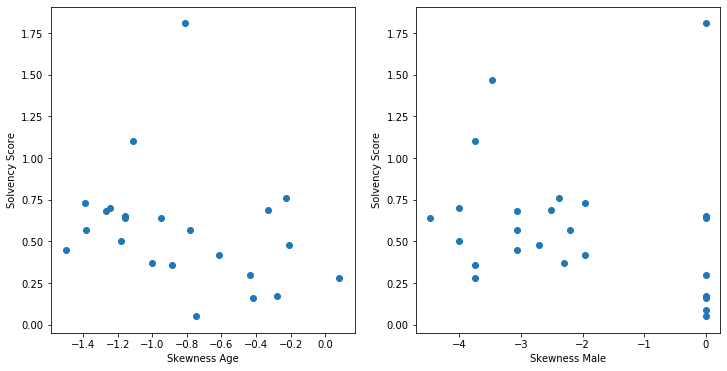

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(df_smry_town_final.skew_age, df_smry_town_final.score)
ax[0].set_xlabel('Skewness Age')
ax[0].set_ylabel('Solvency Score')
ax[1].scatter(df_smry_town_final.skew_male_percentage, df_smry_town_final.score)
ax[1].set_xlabel('Skewness Male')
ax[1].set_ylabel('Solvency Score')


As illustrated in the graph above, the skewness of age and male seems to be negatively correlated with the solvency score.

## Conclusion and Further research

We have conducted an exploratory analysis on the diversity in Japan's local counsil and its performance. The initial analysis suggests that the diversity has some positive impact on the budget solvency in the local town in Japan. We will need a further analysis on the data in the following points.

#### 1. Doesn't this only apply to Yamanashi prefecture?

Due to the limited time constraint, we were only able to collect data in Yamanashi prefecture that had the largest variation in the budget solvency compared with other prefectures. Yet this finding may only apply to this particular prefecture. We will need to collect the data on the diversity in the local counsil members of other prefectures. 

#### 2. Does this really suggest the causation?

It may be the case that small towns and villages with a large population of elderly people naturally has low tax income, and due to the low number of young people its council lack the young members. To some exent, this may be true, but it does not explain the low number of female members. Having more variables to define the diversity will help establish the causal relationship. One possible variable is the diversity on the political ideas, which can be represented by the diversity in the political party that each member belongs to. 

#### 3. Is the budget solvency the right metric to measure the performance of the local council?

The budget solvency may be the result of long time political activities instead of just one result of an election. To account for the long term impact on the budget solvency, it is worth collecting the same diversity score over the last 10 years for example and check wither the diversity score remains the same over the long time and see how the budget solvency changes. 
